# Electric load: Multivariate time series forecasting

The data in this example is taken from the GEFCom2014 forecasting competition*. We use the load data consists of 3 years of hourly electricity load and temperature values between 2012 and 2014.

*Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

Note: This notebook assumes that the directory `data` exists next to this notebook.

In [1]:
! pip install openpyxl

In [ ]:
!pip install seaborn

In [138]:
import zipfile
import sys
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.models.tcn_model import TCNModel
from darts.metrics import mape, smape
from darts.utils.statistics import check_seasonality, plot_acf

data_dir = './data'

# Remove logging as we will produce timeseries of lenght one for the historical forecast. 
logging.disable(sys.maxsize)

In [3]:
def load_data(data_dir):
    main_dir = Path(data_dir) / 'GEFCom2014' / 'GEFCom2014 Data'
    filename = Path(data_dir) / 'GEFCom2014.zip' 
    
    if not filename.exists():
        sys.exit(f"Download GEFCom2014.zip from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and save it to the {data_dir} directory.")

    # Extract the data
    with zipfile.ZipFile(filename, 'r') as f:
        f.extractall(Path(data_dir) / 'GEFCom2014')
        
    with zipfile.ZipFile(Path(main_dir) / 'GEFCom2014-E_V2.zip', 'r') as f:
        f.extractall(Path(data_dir) / 'GEFCom2014-E')
        
    # Load the data
    data = pd.read_excel(
        (Path(data_dir) / 'GEFCom2014-E' / 'GEFCom2014-E.xlsx'),
        parse_dates=['Date'],
        engine='openpyxl')
    
    # Create timestamp column 
    data['timestamp'] = data['Date'].add(pd.to_timedelta(data.Hour - 1, unit='h'))
    data = data[['timestamp', 'load', 'T']].rename(columns={'T':'temperature'})

    # Filter out rows without data for load
    data = data[data.timestamp >= '2012-01-01']

    data.to_csv(Path(data_dir) / 'energy.csv', index=False)

### Extract and load data

In [6]:
if not (Path(data_dir) / 'energy.csv').exists():
    # Download the data (We assume the dir data exists)
    !wget https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip -P ./data
    load_data(data_dir)

In [7]:
df_load = pd.read_csv(Path(data_dir) / 'energy.csv', parse_dates=['timestamp'])
df_load.head(3)

,timestamp,load,temperature
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000


### Explore data

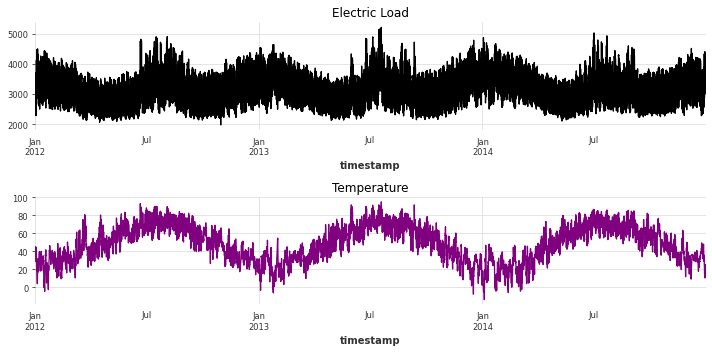

In [206]:
f, ax = plt.subplots(2,1, figsize=(10,5)); ax.ravel()
df_load.set_index('timestamp').load.plot(title='Electric Load', ax=ax[0])
df_load.set_index('timestamp').temperature.plot(title='Temperature', color='purple', ax=ax[1])
plt.tight_layout()

We can see that the electric load has a yearly seasonality that is related with increases or decreases of temperature. We can see this more clearly in a scatterplot:

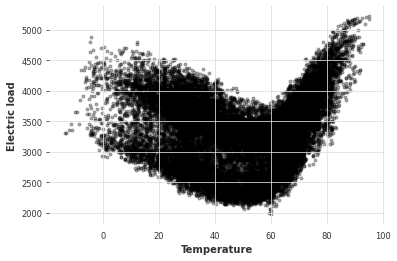

In [221]:
plt.scatter(x=df_load.temperature, y=df_load.load, alpha=0.3, marker='.')
plt.ylabel("Electric load"); plt.xlabel("Temperature");

Let's explore visually the load daily pattern for different days of the week and different months of the year:

In [97]:
df_load['day_name'] = df_load['timestamp'].dt.day_name()
df_load['hour'] = df_load['timestamp'].dt.hour

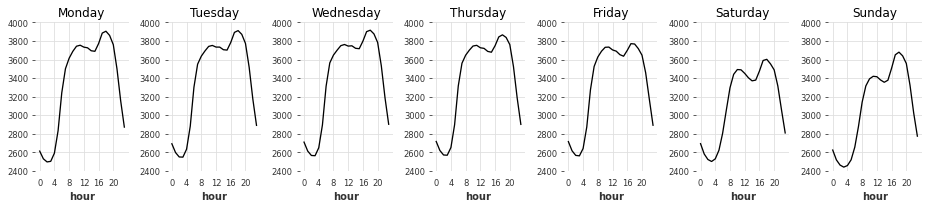

In [111]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(1, 7, figsize=(13,3)); axes=axes.ravel()
for ax, day in zip(axes, days):
    df_load.query('day_name == @day').groupby('hour').load.mean().plot(ax=ax)
    ax.set_title(day); ax.set_ylim([2400, 4000])
    ax.xaxis.set_ticks(range(0,24,4));
plt.tight_layout()

Note that:
- The load exhibits a daily seasonality
- During the weekends the load decreases, producing also a weekly seasonality

Let's also explore the load daily pattern for different months of the year:

In [ ]:
df_load['month'] = df_load['timestamp'].dt.month

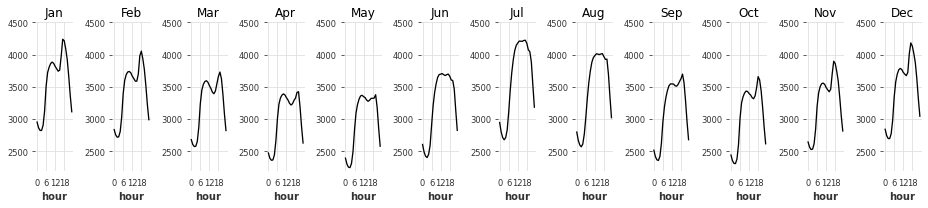

In [124]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, axes = plt.subplots(1, 12, figsize=(13,3)); axes=axes.ravel()
for ax, month in zip(axes, range(1,13)):
    df_load.query('month == @month').groupby('hour').load.mean().plot(ax=ax)
    ax.set_title(months[month-1]); ax.set_ylim([2200, 4500])
    ax.xaxis.set_ticks(range(0,24,6));
plt.tight_layout()

Note that the daily pattern changes both in shape and magnitude for different months of the year

### Preprocessing

Convert both load and temperature to series:

In [132]:
series_load = TimeSeries.from_dataframe(df_load, 'timestamp', ['load'])
series_temp = TimeSeries.from_dataframe(df_load, 'timestamp', ['temperature'])

Scale both timeseries between 0 and 1:

In [22]:
scaler_load, scaler_temp = Scaler(), Scaler() # Question: Shall we do the scaling after the train-test?
series_load_scaled = scaler_load.fit_transform(series_load)
series_temp_scaled = scaler_load.fit_transform(series_temp)

### Train / Validation split

Let's keep the last 24 days of both series as validation

In [237]:
hours_val = 24*42

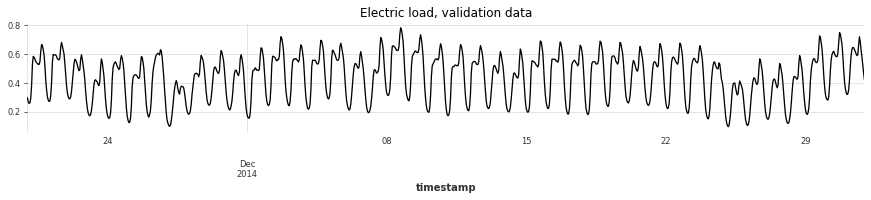

In [233]:
train_load, val_load = series_load_scaled[:-hours_val], series_load_scaled[-hours_val:]
train_temp, val_temp = series_temp_scaled[:-hours_val], series_temp_scaled[-hours_val:]

val_load.plot(title='Electric load, validation data', figsize=(15,2))

## One-hour ahead electric load forecast

### Univariate model

Let's fit a model that only uses the load of the previous 48 hours:
\begin{align}
\hat{y}_{t} = f(y_{t-1}, y_{t-2},...,y_{t-48}) + e_{t}
\end{align}

The choise of 48 hours based on this paper: [Electric Load Forecasting](https://www.esat.kuleuven.be/sista/lssvmlab/mfo/espinoza.pdf). However, it should be selected for each dataset through experimentation.

##### RNN

In [38]:
model_load_univariate = RNNModel(
                            model='RNN',
                            input_length=48,
                            output_length=1,
                            input_size=1,
                            output_size=1,
                            n_epochs=30)
model_load_univariate.fit(train_load)

As we are just predicting one step into the future (the next hour), it does not make sense to use the predict function to evaluate the model performance. Let's use instead the historical forecast:

MAPE = 3.14%


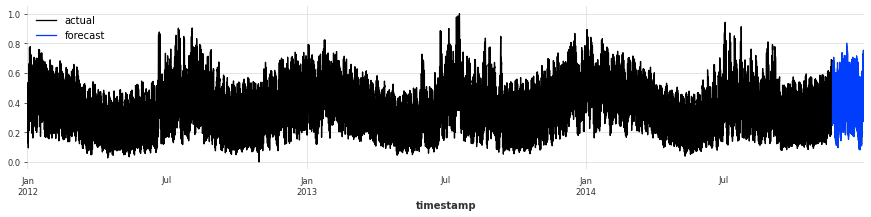

In [266]:
backtest_cov = model_load_univariate.historical_forecasts(series_load_scaled,
                                              start=len(df_load)-hours_val+1, # matches the validation set start
                                              forecast_horizon=1,
                                              stride=1,
                                              retrain=False,
                                              verbose=False)

series_load_scaled.plot(label='actual')
backtest_cov.plot(label='forecast', figsize=(15,3))
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_load_scaled, backtest_cov)))

Let's get a more granular view of the backtest:

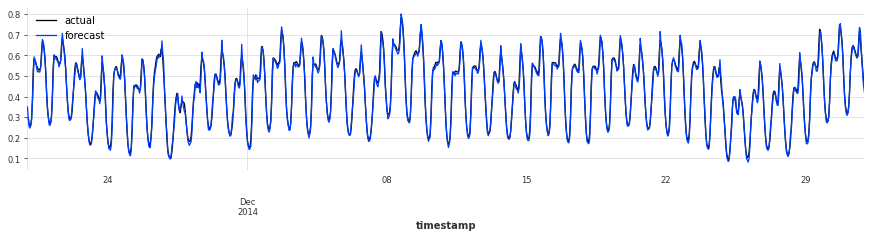

In [247]:
series_load_scaled[-hours_val:].plot(label='actual')
backtest_cov.plot(label='forecast', figsize=(15,3))
plt.legend();

Last days of december:

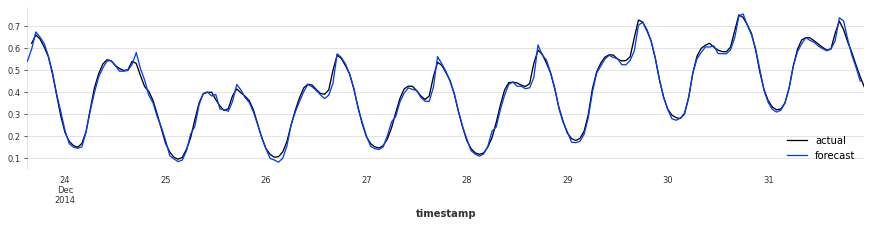

In [48]:
series_load_scaled[-200:].plot(label='actual')
backtest_cov[-200:].plot(label='forecast', figsize=(15,3))
plt.legend();

First days of november

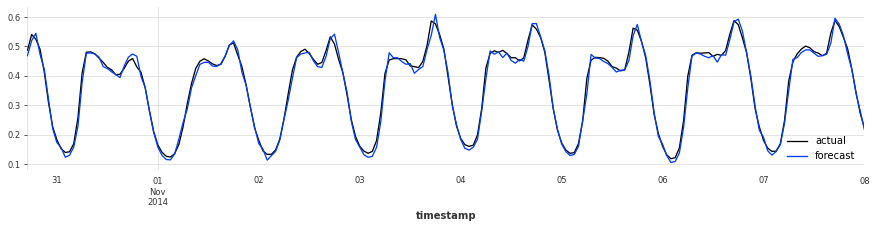

In [54]:
series_load_scaled[:pd.Timestamp('2014-11-08')][-200:].plot(label='actual')
backtest_cov[:pd.Timestamp('2014-11-08')][-200:].plot(label='forecast', figsize=(15,3))
plt.legend();

Our one-hour forecast does quite well. We could have a lower MAPE according to this modeling: https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/2_RNN.ipynb

### Multivariate model

Let's fit a model that uses the load and the temperature of the previous 48 hours, as well as holidays information:
\begin{align}
\hat{y}_{t} = f(y_{t-1},...,y_{t-48},t_{t-1},...,t_{t-48})  + e_{t}
\end{align}

In [270]:
series_augmented = series_load_scaled.add_holidays('US').stack(series_temp_scaled)
train_augmented = train_load.add_holidays('US').stack(train_temp)

In [273]:
model_load_multiv = RNNModel(        
                            model='RNN',
                            input_length=48,
                            output_length=1,
                            input_size=3,
                            output_size=1,
                            n_epochs=30)

model_load_multiv.fit(target_series=train_augmented['0'],
                            training_series=train_augmented,
                           )


MAPE = 3.05%


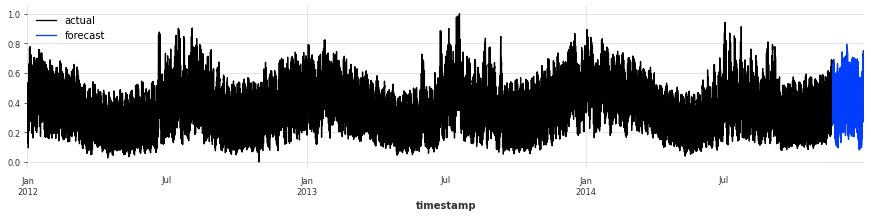

In [275]:
backtest_cov = model_load_multiv.historical_forecasts(
    series_augmented,
    start=len(df_load)-hours_val+1, # matches the validation set start
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True,
    use_full_output_length=True)

series_load_scaled.plot(label='actual')
backtest_cov.plot(label='forecast', figsize=(15,3))
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_load_scaled, backtest_cov)))

Note that the multivariate model MAPE is lightly better than the univariate one (3.15%). Again, let's get a more granular view of the backtest:

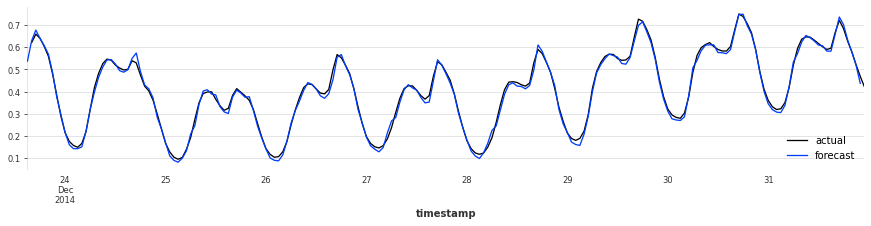

In [276]:
series_load_scaled[-200:].plot(label='actual')
backtest_cov[-200:].plot(label='forecast', figsize=(15,3))
plt.legend();

## 24-hour ahead electric load forecast

### Univariate model

In [176]:
model_load_univariate24 = RNNModel(
                            model='RNN',
                            input_length=48,
                            output_length=24,
                            input_size=1,
                            output_size=1,
                            n_epochs=30)
model_load_univariate24.fit(train_load)

MAPE: 8.21%.


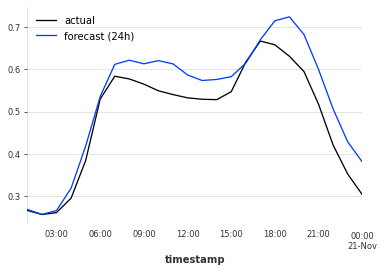

In [199]:
next_24_hours_prediction = model_load_univariate24.predict(24)
val_load[:24].plot(label='actual')
next_24_hours_prediction.plot(label='forecast (24h)')
plt.legend();
print("MAPE: {:.2f}%.".format(
      mape(next_24_hours_prediction, val_load[:24])))

Let's inspect the historical forecast:

MAPE = 24.20%


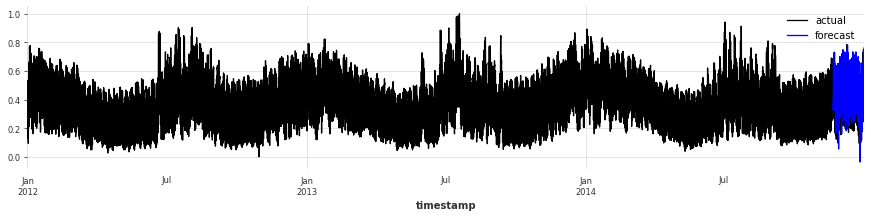

In [263]:
backtest_cov = model_load_univariate24.historical_forecasts(series_load_scaled,
                                              start=len(df_load)-hours_val+1, # matches the validation set start
                                              forecast_horizon=24,
                                              stride=1,
                                              retrain=False,
                                              verbose=False)

series_load_scaled.plot(label='actual')
backtest_cov.plot(label='forecast (24h)', figsize=(15,3), color='b')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_load_scaled, backtest_cov)))

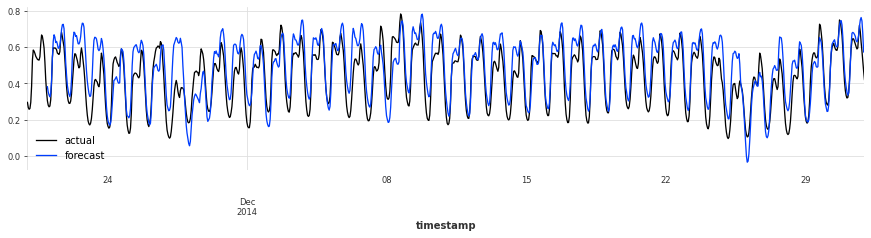

In [264]:
series_load_scaled[-hours_val:].plot(label='actual')
backtest_cov.plot(label='forecast', figsize=(15,3))
plt.legend();

### Multivariate model

In [277]:
model_load_multiv24 = RNNModel(        
                            model='RNN',
                            input_length=48,
                            output_length=24,
                            input_size=3,
                            output_size=1,
                            n_epochs=30)

model_load_multiv24.fit(target_series=train_augmented['0'],
                            training_series=train_augmented,
                           )

MAPE: 3.68%.


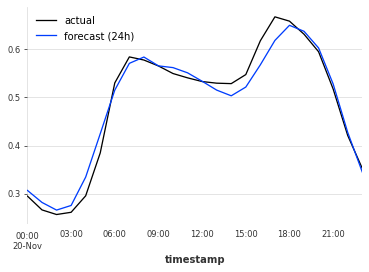

In [279]:
next_24_hours_prediction = model_load_multiv24.predict(24, use_full_output_length=True)
val_load[:24].plot(label='actual')
next_24_hours_prediction.plot(label='forecast (24h)')
plt.legend();
print("MAPE: {:.2f}%.".format(
      mape(next_24_hours_prediction, val_load[:24])))


MAPE = 13.75%


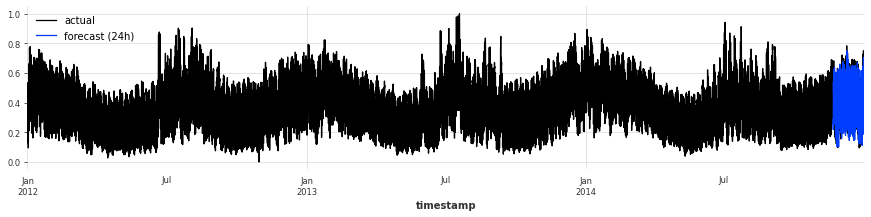

In [283]:
backtest_cov = model_load_multiv24.historical_forecasts(
    series_augmented,
    start=len(df_load)-hours_val+1, # matches the validation set start
    forecast_horizon=24,
    stride=1,
    retrain=False,
    verbose=True,
    use_full_output_length=True)

series_load_scaled.plot(label='actual')
backtest_cov.plot(label='forecast (24h)', figsize=(15,3))
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_load_scaled, backtest_cov)))

Note that in this case the multivariate model MAPE is much better than the univariate one (24.20%). Again, let's get a more granular view of the backtest:

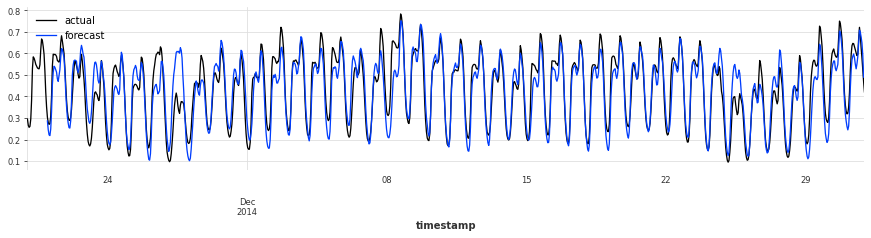

In [282]:
series_load_scaled[-hours_val:].plot(label='actual')
backtest_cov.plot(label='forecast', figsize=(15,3))
plt.legend();

#### Add future holidays and temperature information

In [318]:
shift_hours = 24
series_augmented_future = series_augmented[:-shift_hours].stack(
    series_augmented[['1','2']].shift(-shift_hours)[shift_hours:]
    )
train_augmented_future = train_augmented[:-shift_hours].stack(
    train_augmented[['1','2']].shift(-shift_hours)[shift_hours:]
    )

In [321]:
model_load_multiv24 = RNNModel(        
                            model='RNN',
                            input_length=48,
                            output_length=24,
                            input_size=5, # Note we change input size to add future information
                            output_size=1,
                            n_epochs=30)

model_load_multiv24.fit(target_series=train_augmented_future['0'],
                            training_series=train_augmented_future,
                           )

MAPE: 4.99%.


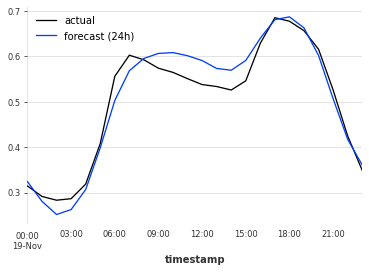

In [325]:
next_24_hours_prediction = model_load_multiv24.predict(24, use_full_output_length=True)
train_load[-24:].plot(label='actual')
next_24_hours_prediction.plot(label='forecast (24h)')
plt.legend();
print("MAPE: {:.2f}%.".format(
      mape(next_24_hours_prediction, train_load[-24:])))


MAPE = 12.73%


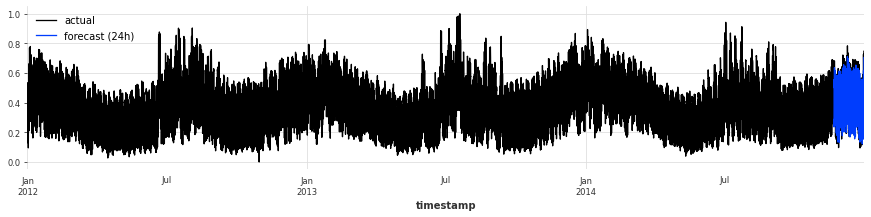

In [326]:
backtest_cov = model_load_multiv24.historical_forecasts(
    series_augmented_future,
    start=len(df_load)-hours_val+1, # matches the validation set start
    forecast_horizon=24,
    stride=1,
    retrain=False,
    verbose=True,
    use_full_output_length=True)

series_augmented_future['0'].plot(label='actual')
backtest_cov.plot(label='forecast (24h)', figsize=(15,3))
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_load_scaled, backtest_cov)))

Note that in this case the multivariate model MAPE is much better than the univariate one (24.20%). Again, let's get a more granular view of the backtest:

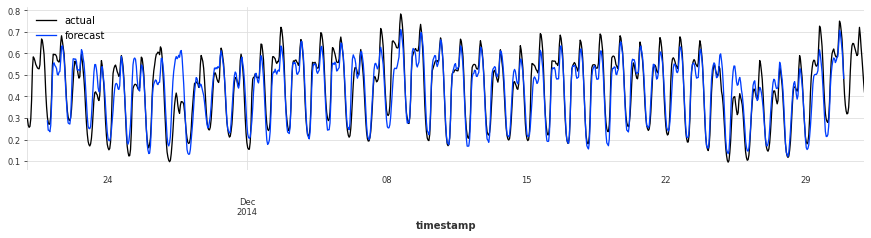

In [336]:
series_load_scaled[-hours_val:].plot(label='actual')
backtest_cov.plot(label='forecast', figsize=(15,3))
plt.legend();

Still, we are overpredicting the 25th of December...

# ToFix: Series of holidays

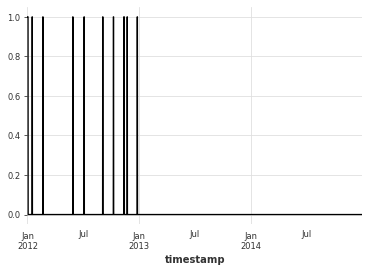

In [388]:
series_load.add_holidays('US')['timestamp'].plot()

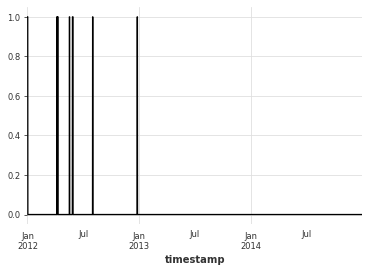

In [353]:
series_load.add_holidays('CH')['timestamp'].plot()

TODO:
- Add calendar information (month M, weekday W, hour H)
- Process the temperature into three different variables:
    - A variable that captures the cooling requirement when the temperature rises above 20°C: max(t-20, 0)
    - A heating variable when temperature drops below 16.5°C: max(16.5-t, 0)
    - An extra-heating variable when the temperature drops below 5°C: max(5-t, 0)